In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils import gt_cvx, soft_thr

sns.set_theme()
sns.set_context("paper")


experiment_dir = "./experiments/"
fig_dir = os.path.join(experiment_dir, "figures")
os.makedirs(fig_dir, exist_ok=True)


/cis/home/zfang23/miniconda3/envs/lpn_public/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
RESULTS_DIR = "experiments/results/"
NORMALIZE = True  # normalize the offset

model2file = {
    "L2": "l2",
    "L1": "l1",
    "PM_0.5": "l_0.5",
    "PM_0.4": "l_0.4",
    "PM_0.3": "l_0.3",
    "PM_0.2": "l_0.2",
    "PM_0.1": "l_0.1",
}

model2label = {
    "L2": r"$\ell_2$",
    "L1": r"$\ell_1$",
    "PM_0.5": r"$\mathcal{L}_{PM}, \gamma=0.5$",
    "PM_0.4": r"$\mathcal{L}_{PM}, \gamma=0.4$",
    "PM_0.3": r"$\mathcal{L}_{PM}, \gamma=0.3$",
    "PM_0.2": r"$\mathcal{L}_{PM}, \gamma=0.2$",
    "PM_0.1": r"$\mathcal{L}_{PM}, \gamma=0.1$",
}

model_list = ["L2", "L1", "PM_0.5", "PM_0.3", "PM_0.1"]

x_dict = {}
y_dict = {}
c_dict = {}
p_dict = {}
for m in model_list:
    results = np.load(
        os.path.join(RESULTS_DIR, model2file[m] + ".npy"), allow_pickle=True
    ).item()
    x_dict[m] = results["x"]
    y_dict[m] = results["y"]
    c_dict[m] = results["c"]
    p_dict[m] = results["p"]


In [3]:
if NORMALIZE:
    for m in model_list:
        c_dict[m] = c_dict[m] - np.min(c_dict[m])
        p_dict[m] = p_dict[m] - np.min(p_dict[m])


In [4]:
# set x limit
xlim = [-3.5, 3.5]

for m in model_list:
    idx = np.argwhere((x_dict[m] > xlim[0]) & (x_dict[m] < xlim[1]))[:, 0]
    x_dict[m] = x_dict[m][idx]
    y_dict[m] = y_dict[m][idx]
    c_dict[m] = c_dict[m][idx]
    p_dict[m] = p_dict[m][idx]


## Plot

In [5]:
sns.set_palette(sns.color_palette(["tab:blue", "tab:orange", "tab:green", "#84817A"]))


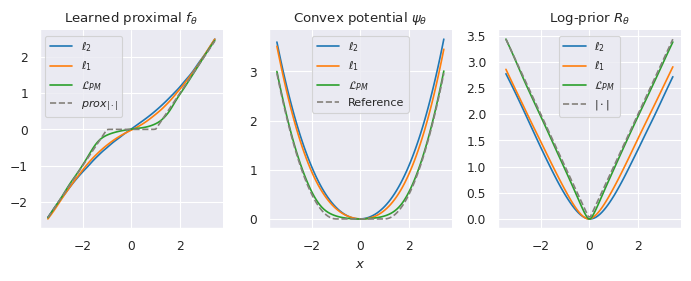

In [6]:
# Create a figure with 1 row, 3 columns
# columns 1-3: learned prox, convex function, original function
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(7, 2.9))

# learned prox, L2, L1, and PM
ax = axes[0]
for i, (model, lb) in enumerate(
    zip(["L2", "L1", "PM_0.1"], [r"$\ell_2$", r"$\ell_1$", r"$\mathcal{L}_{PM}$"])
):
    x = x_dict[model]
    y = y_dict[model]
    ax.plot(x, y, label=lb)
ax.plot(x, soft_thr(x), "--", label=r"$prox_{|\cdot|}$")
ax.legend(loc="upper left", fontsize="small")
ax.set_title(r"Learned proximal $f_\theta$")

# convex function, L2, L1, and PM
ax = axes[1]

for i, (model, lb) in enumerate(
    zip(["L2", "L1", "PM_0.1"], [r"$\ell_2$", r"$\ell_1$", r"$\mathcal{L}_{PM}$"])
):
    x = x_dict[model]
    c = c_dict[model]
    ax.plot(x, c, label=lb)
ax.plot(x, gt_cvx(x), "--", label="Reference")
ax.legend(loc="upper center", fontsize="small")
ax.set_title(r"Convex potential $\psi_\theta$")

# original function, L2, L1, and PM
ax = axes[2]
for i, (model, lb) in enumerate(
    zip(["L2", "L1", "PM_0.1"], [r"$\ell_2$", r"$\ell_1$", r"$\mathcal{L}_{PM}$"])
):
    x = x_dict[model]
    p = p_dict[model]
    ax.plot(x, p, label=lb)
ax.plot(x, np.abs(x), "--", label=r"$|\cdot|$")
ax.legend(loc="upper center", fontsize="small")
ax.set_title(r"Log-prior $R_\theta$")

axes[1].set_xlabel(r"$x$")

sns.despine()
fig.tight_layout()

fig.savefig(os.path.join(fig_dir, "laplacian_compact.pdf"), bbox_inches="tight")
fig.savefig(
    os.path.join(fig_dir, "laplacian_compact.png"), bbox_inches="tight", dpi=300
)
fig.show()
